In [ ]:
from qiskit.circuit import QuantumCircuit
from typing import List, Optional, Sequence
from qiskit.providers.backend import Backend
from qiskit_experiments.framework import BaseExperiment, Options

class CustomExperiment(BaseExperiment):
    """Custom experiment class template."""

    def __init__(self,
                 physical_qubits: Sequence[int],
                 backend: Optional[Backend] = None):
        """Initialize the experiment."""
        super().__init__(physical_qubits,
                         analysis = CustomAnalysis(),
                         backend = backend)

    def circuits(self) -> List[QuantumCircuit]:
        """Generate the list of circuits to be run."""
        circuits = []
        # Generate circuits and populate metadata here
        for i in loops:
            circ = QuantumCircuit(self.num_qubits)
            circ.metadata = {}
            circuits.append(circ)
        return circuits

    @classmethod
    def _default_experiment_options(cls) -> Options:
        """Set default experiment options here."""
        options = super()._default_experiment_options()
        options.update_options(
            dummy_option = None,
        )
        return options

In [ ]:
import matplotlib
from typing import Tuple, List
from qiskit_experiments.framework import (
    BaseAnalysis,
    Options,
    ExperimentData,
    AnalysisResultData
)

class CustomAnalysis(BaseAnalysis):
    """Custom analysis class template."""

    @classmethod
    def _default_options(cls) -> Options:
        """Set default analysis options. Plotting is on by default."""

        options = super()._default_options()
        options.dummy_analysis_option = None
        options.plot = True
        options.ax = None
        return options

    def _run_analysis(
        self,
        experiment_data: ExperimentData
    ) -> Tuple[List[AnalysisResultData], List["matplotlib.figure.Figure"]]:
        """Run the analysis."""

        # Process the data here

        analysis_results = [
            AnalysisResultData(name="dummy result", value=data)
        ]
        figures = []
        if self.options.plot:
            figures.append(self._plot(data))
        return analysis_results, figures

In [ ]:
from numpy.random import default_rng, Generator
from qiskit import QuantumCircuit
from qiskit.quantum_info import random_pauli_list
from qiskit_experiments.framework import BaseExperiment

class RandomizedMeasurement(BaseExperiment):
"""Randomized measurement experiment."""
    def __init__(
        self,
        circuit,
        measured_qubits=None,
        physical_qubits=None,
        backend=None,
        num_samples=10,
        seed=None
    ):
        """Basic randomized Z-basis measurement experiment via a Pauli frame transformation

        Note this will just append a new set of measurements at the end of a circuit.
        A more advanced version of this experiment would be to use a transpiler pass to
        replace all existing measurements in a circuit with randomized measurements.
        """
        if physical_qubits is None:
            physical_qubits = tuple(range(circuit.num_qubits))
        if measured_qubits is None:
            measured_qubits = tuple(range(circuit.num_qubits))

        # Initialize BaseExperiment
        analysis = RandomizedMeasurementAnalysis()
        super().__init__(physical_qubits, analysis=analysis, backend=backend)

        # Add experiment properties
        self._circuit = circuit
        self._measured_qubits = measured_qubits

        # Set any init optinos
        self.set_experiment_options(num_samples=num_samples, seed=seed)

In [ ]:
...

    @classmethod
    def _default_experiment_options(cls):
        options = super()._default_experiment_options()
        options.num_samples = None
        options.seed = None
        return options

In [ ]:
...


    def circuits(self):
        # Number of classical bits of the original circuit
        circ_nc = self._circuit.num_clbits

        # Number of added measurements
        meas_nc = len(self._measured_qubits)

        # Classical bits of the circuit
        circ_clbits = list(range(circ_nc))

        # Classical bits of the added measurements
        meas_clbits = list(range(circ_nc, circ_nc + meas_nc))

        # Qubits of the circuit
        circ_qubits = list(range(self.num_qubits))

        # Qubits of the added measurements
        meas_qubits = self._measured_qubits

        # Get number of samples from options
        num_samples = self.experiment_options.num_samples
        if num_samples is None:
            num_samples = 2 ** self.num_qubits

        # Get rng seed
        seed = self.experiment_options.seed
        if isinstance(seed, Generator):
            rng = seed
        else:
            rng = default_rng(seed)

        paulis = random_pauli_list(meas_nc, size=num_samples, phase=False, seed=rng)

In [ ]:
...

    # Construct circuits
    circuits = []
    orig_metadata = self._circuit.metadata or {}
    for pauli in paulis:
        name = f"{self._circuit.name}_{str(pauli)}"
        circ = QuantumCircuit(
            self.num_qubits, circ_nc + meas_nc,
            name=name
        )
        # Append original circuit
        circ.compose(
            self._circuit, circ_qubits, circ_clbits, inplace=True
        )

        # Add Pauli frame
        circ.compose(pauli, meas_qubits, inplace=True)

        # Add final measurement
        circ.measure(meas_qubits, meas_clbits)

        circ.metadata = orig_metadata.copy()
        circ.metadata["rm_bits"] = meas_clbits
        circ.metadata["rm_frame"] = str(pauli)
        circ.metadata["rm_sig"] = pauli.x.astype(int).tolist()
        circuits.append(circ)
    return circuits

In [ ]:
from qiskit_experiments.framework import BaseAnalysis, AnalysisResultData

class RandomizedMeasurementAnalysis(BaseAnalysis):
    """Analysis for randomized measurement experiment."""

    def _run_analysis(self, experiment_data):

        combined_counts = {}
        for datum in experiment_data.data():
            # Get counts
            counts = datum["counts"]
            num_bits = len(next(iter(counts)))

            # Get metadata
            metadata = datum["metadata"]
            clbits = metadata["rm_bits"]
            sig = metadata["rm_sig"]

            # Construct full signature
            full_sig = num_bits * [0]
            for bit, val in zip(clbits, sig):
                full_sig[bit] = val

            # Combine dicts
            for key, val in counts.items():
                bitstring = self._swap_bitstring(key, full_sig)
                if bitstring in combined_counts:
                    combined_counts[bitstring] += val
                else:
                    combined_counts[bitstring] = val

        result = AnalysisResultData("counts", combined_counts)
        return [result], []

In [ ]:
...
    # Helper dict to swap a clbit value
    _swap_bit = {"0": "1", "1": "0"}

    @classmethod
    def _swap_bitstring(cls, bitstring, sig):
        """Swap a bitstring based signature to flip bits at."""
        # This is very inefficient but demonstrates the basic idea
        return "".join(reversed(
            [cls._swap_bit[b] if sig[- 1 - i] else b for i, b in enumerate(bitstring)]
        ))

In [1]:
# this is the actual code that defines the experiment so the experiment execution code below can work

from numpy.random import default_rng, Generator
from qiskit import QuantumCircuit
from qiskit_experiments.framework import BaseExperiment
from qiskit.quantum_info import random_pauli_list

class RandomizedMeasurement(BaseExperiment):
  def __init__(
      self,
      circuit,
      measured_qubits=None,
      physical_qubits=None,
      backend=None,
      num_samples=10,
      seed=None
  ):

      if physical_qubits is None:
          physical_qubits = tuple(range(circuit.num_qubits))
      if measured_qubits is None:
          measured_qubits = tuple(range(circuit.num_qubits))

      analysis = RandomizedMeasurementAnalysis()
      super().__init__(physical_qubits, analysis=analysis, backend=backend)

      self._circuit = circuit
      self._measured_qubits = measured_qubits

      self.set_experiment_options(num_samples=num_samples, seed=seed)

  @classmethod
  def _default_experiment_options(cls):
      options = super()._default_experiment_options()
      options.num_samples = None
      options.seed = None
      return options

  def circuits(self):
      circ_nc = self._circuit.num_clbits
      meas_nc = len(self._measured_qubits)
      circ_qubits = list(range(self.num_qubits))
      circ_clbits = list(range(circ_nc))
      meas_qubits = self._measured_qubits
      meas_clbits = list(range(circ_nc, circ_nc + meas_nc))

      num_samples = self.experiment_options.num_samples
      if num_samples is None:
          num_samples = 2 ** self.num_qubits

      seed = self.experiment_options.seed
      if isinstance(seed, Generator):
          rng = seed
      else:
          rng = default_rng(seed)

      paulis = random_pauli_list(meas_nc, size=num_samples, phase=False, seed=rng)

      circuits = []
      orig_metadata = self._circuit.metadata or {}
      for pauli in paulis:
          name = f"{self._circuit.name}_{str(pauli)}"
          circ = QuantumCircuit(
              self.num_qubits, circ_nc + meas_nc,
              name=name
          )
          circ.compose(
              self._circuit, circ_qubits, circ_clbits, inplace=True
          )
          circ.compose(pauli, meas_qubits, inplace=True)
          circ.measure(meas_qubits, meas_clbits)
          circ.metadata = orig_metadata.copy()
          circ.metadata["rm_bits"] = meas_clbits
          circ.metadata["rm_sig"] = pauli.x.astype(int).tolist()

          circuits.append(circ)

      return circuits

from qiskit_experiments.framework import BaseAnalysis, AnalysisResultData

class RandomizedMeasurementAnalysis(BaseAnalysis):
    """Analysis for randomized measurement experiment."""

    # Helper dict to swap a clbit value
    _swap_bit = {"0": "1", "1": "0"}

    def _run_analysis(self, experiment_data):

        combined_counts = {}
        for datum in experiment_data.data():
            counts = datum["counts"]
            num_bits = len(next(iter(counts)))
            metadata = datum["metadata"]
            clbits = metadata["rm_bits"]
            sig = metadata["rm_sig"]
            full_sig = num_bits * [0]
            for bit, val in zip(clbits, sig):
                full_sig[bit] = val
            for key, val in counts.items():
                bitstring = self._swap_bitstring(key, full_sig)
                if bitstring in combined_counts:
                    combined_counts[bitstring] += val
                else:
                    combined_counts[bitstring] = val


        result = AnalysisResultData("counts", combined_counts)
        return [result], []

    @classmethod
    def _swap_bitstring(cls, bitstring, sig):
        """Swap a bitstring based signature to flip bits at."""
        # This is very inefficient but demonstrates the basic idea
        # Really should do with bitwise operations of integer counts rep
        return "".join(reversed(
            [cls._swap_bit[b] if sig[- 1 - i] else b for i, b in enumerate(bitstring)]
        ))

In [2]:
from qiskit.providers.aer import AerSimulator, noise

backend_ideal = AerSimulator()

# Backend with asymetric readout error
p0g1 = 0.3
p1g0 = 0.05
noise_model = noise.NoiseModel()
noise_model.add_all_qubit_readout_error([[1 - p1g0, p1g0], [p0g1, 1 - p0g1]])
noise_backend = AerSimulator(noise_model=noise_model)

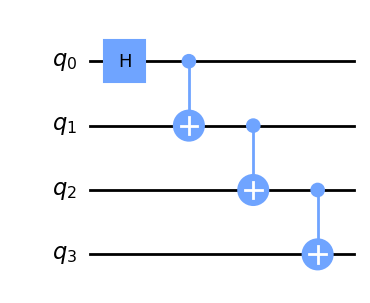

In [3]:
# GHZ Circuit
nq = 4
qc = QuantumCircuit(nq)
qc.h(0)
for i in range(1, nq):
    qc.cx(i-1, i)

qc.draw("mpl")

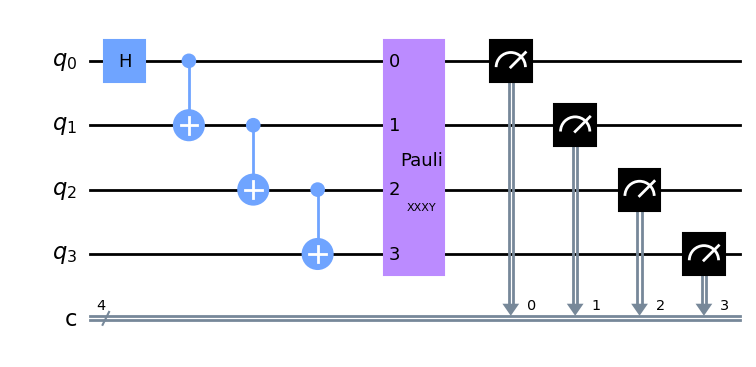

In [4]:
# Experiment parameters
total_shots = 100000
num_samples = 50
shots = total_shots // num_samples

# Run ideal randomized meas experiment
exp = RandomizedMeasurement(qc, num_samples=num_samples)
exp.circuits()[0].draw("mpl")

In [5]:
expdata_ideal = exp.run(AerSimulator(), shots=shots)
counts_ideal = expdata_ideal.analysis_results("counts").value
print(counts_ideal)

{'1111': 49813, '0000': 50187}


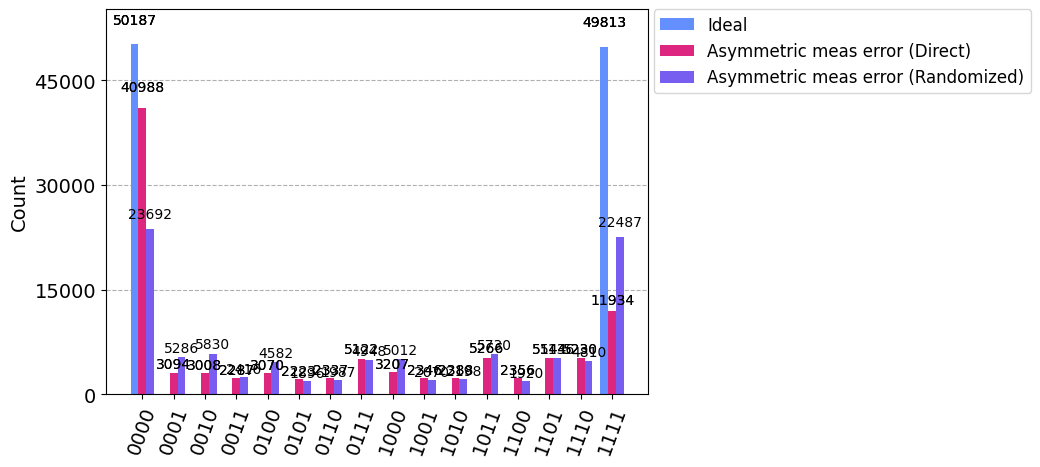

In [6]:
# Run noisy randomized meas experiment with readout error
expdata_noise = exp.run(noise_backend, shots=shots)
counts_noise = expdata_noise.analysis_results("counts").value

# Run noisy simulation of the original circuit without randomization
meas_circ = qc.copy()
meas_circ.measure_all()
result = noise_backend.run(meas_circ, shots=total_shots).result()
counts_direct = result.get_counts(0)

from qiskit.visualization import plot_histogram

# Plot counts, ideally randomized one should be more symmetric in noise
# than direct one with asymmetric readout error
plot_histogram([counts_ideal, counts_direct, counts_noise],
            legend=["Ideal",
                    "Asymmetric meas error (Direct)",
                    "Asymmetric meas error (Randomized)"])

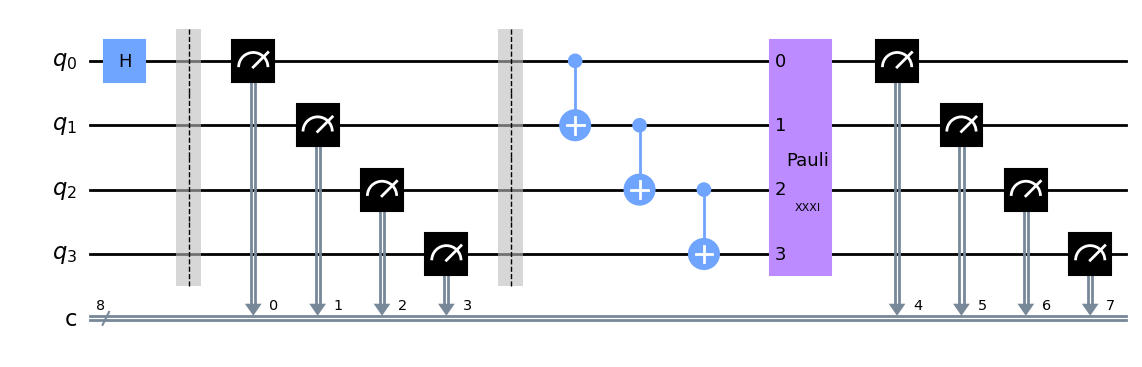

In [7]:
qc = QuantumCircuit(nq)
qc.h(0)
qc.measure_all()
qc.barrier()
for i in range(1, nq):
    qc.cx(i-1, i)

exp = RandomizedMeasurement(qc, num_samples=num_samples)
exp.circuits()[0].draw("mpl")